  Woche                   Datum  Gesamtverkäufe (€)  Kosten (€)  \
0     1  01.01.2024- 07.01.2024               10000        7000   
1     2  08.01.2024- 15.01.2024               12000        8000   

   Anzahl der Verkäufe  Rückgaben (€)  Beschädigte Ware (€) Datum_parsed  \
0                  150            300                   100   2024-01-01   
1                  180            250                   120   2024-01-08   

   Wochen_Differenz  Ertrag (€)  Gewinn (€)  Ertrag_Prozent_Änderung  \
0               NaN        9600        2600                      NaN   
1               1.0       11630        3630                21.145833   

   Gewinn_Prozent_Änderung  Gesamtverkäufe_Prozent_Änderung  \
0                      NaN                              NaN   
1                39.615385                             20.0   

   Kosten_Prozent_Änderung  Anzahl_Verkäufe_Prozent_Änderung  \
0                      NaN                               NaN   
1                14.285714        

KeyError: 'Anzahl der Verkäufen'

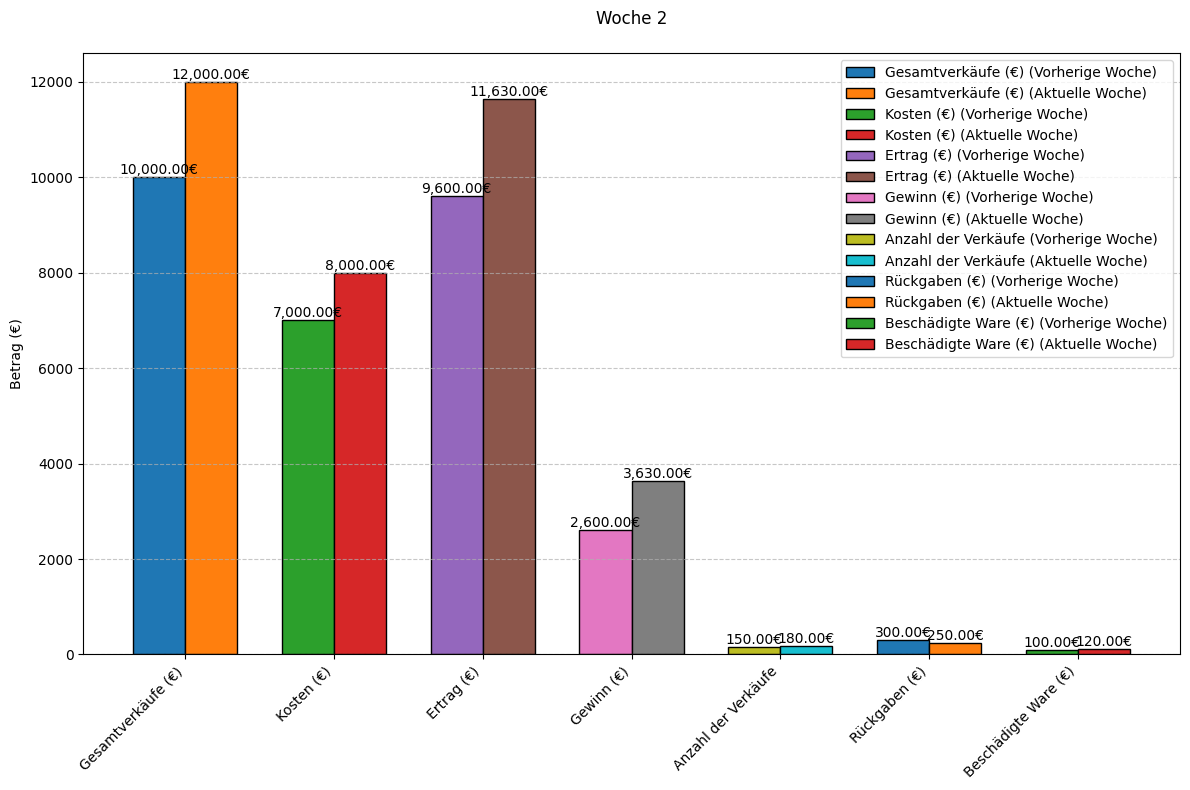

In [19]:
# data_export.py

from typing import Optional

import os
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Inches, Pt
from matplotlib.figure import Figure


def create_report_template():
    # Ensure templates directory exists
    templates_dir = os.path.join("..", "templates")
    if not os.path.exists(templates_dir):
        os.makedirs(templates_dir)

    # Create new document
    doc = Document()

    # Add title
    title = doc.add_heading(level=1)
    title_run = title.add_run("Bericht [week]")
    title_run.font.size = Pt(16)
    title.alignment = WD_ALIGN_PARAGRAPH.CENTER

    # Add sections with placeholder text
    sections = [
        "Wochenbericht",
        "Vergleich zur vorherigen Woche",
    ]

    for section in sections:
        doc.add_heading(section, level=2)
        doc.add_paragraph(f"[{section.lower().replace(' ', '')}]")

    # Add placeholder for potential images
    doc.add_paragraph("[image]").alignment = WD_ALIGN_PARAGRAPH.CENTER

    # Use os.path.join to build the save path correctly
    template_path = os.path.join(templates_dir, "report_template.docx")
    doc.save(template_path)

    print(f"Template saved at: {os.path.abspath(template_path)}")


def insert_content(
    content_dict: dict[str, str],
    image: Figure,
    template_path: Optional[str] = r".\templates\report_template.docx",
) -> str:
    """
    Insert actual content into the template

    content_dict should be a dictionary with keys matching section names
    and values containing the text and image paths
    """
    doc = Document(template_path)

    # Replace the week placeholder in title
    for paragraph in doc.paragraphs:
        if "[week]" in paragraph.text:
            for run in paragraph.runs:
                run.text = run.text.replace("[week]", content_dict.get("week", ""))

    # Replace content placeholders
    for paragraph in doc.paragraphs:
        if "[wochenbericht]" in paragraph.text:
            paragraph.text = content_dict.get("Wochenbericht", "")
        elif "[vergleichzurvorherigenwoche]" in paragraph.text:
            paragraph.text = content_dict.get("Vergleich zur vorherigen Woche", "")

        # Replace image placeholder with actual image
        if "[image]" in paragraph.text:
            paragraph.text = ""  # Clear the placeholder text
            # Save the matplotlib figure to a temporary file
            image.savefig("temp_plot.png")
            # Add the image to the document
            doc.add_picture("temp_plot.png", width=Inches(6))  # Adjust width as needed
            # Remove temporary file
            import os

            os.remove("temp_plot.png")

    doc.save("report_final.docx")

#------------------------------------------------------------------------------------------------------------------
# dataloader.py

from typing import Optional

import pandas as pd
from loguru import logger


def load_data(
    data_path: Optional[str] = "./testdaten/testdaten-excel.xlsx", # load_data()
) -> pd.DataFrame | None:
    # Define the needed columns for the report creation
    df_entries = [
        "Woche",
        "Datum",
        "Gesamtverkäufe (€)",
        "Kosten (€)",
        "Anzahl der Verkäufe",
        "Rückgaben (€)",
        "Beschädigte Ware (€)",
    ]

    # Read the Excel file
    df = pd.read_excel(data_path) # на выходе -> DataFrame

    if len(df) == 0:
        logger.critical("No data found or empty excel file")
        return None

    # Check if all required columns are present
    missing_columns = [col for col in df_entries if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    # Select only the required columns, if more are provided they are ignored
    df = df[df_entries]

    # Get dates of rows with missing values
    rows_with_na = df[df.isna().any(axis=1)]
    if not rows_with_na.empty:
        logger.warning(
            f"Found rows with missing values for dates: {rows_with_na['Datum'].tolist()}"
        )

    return df


def load_test_data(
    data_path: Optional[str] = "./testdaten/testdaten.csv",
) -> pd.DataFrame | None:
    # Define the needed columns for the report creation
    df_entries = [
        "Woche",
        "Datum",
        "Gesamtverkäufe (€)",
        "Kosten (€)",
        "Anzahl der Verkäufe",
        "Rückgaben (€)",
        "Beschädigte Ware (€)",
    ]

    # Read the Excel file
    df = pd.read_csv(data_path)

    if len(df) == 0:
        logger.critical("No data found or empty excel file")
        return None

    # Check if all required columns are present
    missing_columns = [col for col in df_entries if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    # Select only the required columns, if more are provided they are ignored
    df = df[df_entries]

    # Get dates of rows with missing values
    rows_with_na = df[df.isna().any(axis=1)]
    if not rows_with_na.empty:
        logger.warning(
            f"Found rows with missing values for dates: {rows_with_na['Datum'].tolist()}"
        )

    return df


#------------------------------------------------------------------------------------------------------------------------------------------
# data_preperation.py

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.figure import Figure


def prepare_data(data: pd.DataFrame) -> pd.DataFrame:
    # Prepare the data for week differenz
    data["Woche"] = data["Woche"].astype(str)
    data["Datum_parsed"] = data["Datum"].apply(
        lambda x: pd.to_datetime(
            x.replace(" ", "").split("-")[0].strip(), format="%d.%m.%Y"
        )
    )
    # Calculate the week difference
    data["Wochen_Differenz"] = (
        data["Datum_parsed"] - data["Datum_parsed"].shift(1)
    ).dt.days / 7

    # Calculate Yield per week
    data["Ertrag (€)"] = (
        data["Gesamtverkäufe (€)"]
        - data["Rückgaben (€)"]
        - data["Beschädigte Ware (€)"]
    )

    # Calculate Profit per week
    data["Gewinn (€)"] = data["Ertrag (€)"] - data["Kosten (€)"]

    # Calculate Percentage Changes from previous week
    data["Ertrag_Prozent_Änderung"] = data["Ertrag (€)"].pct_change() * 100
    data["Gewinn_Prozent_Änderung"] = data["Gewinn (€)"].pct_change() * 100
    data["Gesamtverkäufe_Prozent_Änderung"] = data["Gesamtverkäufe (€)"].pct_change() * 100
    
    data["Kosten_Prozent_Änderung"] = data["Kosten (€)"].pct_change() * 100
    data["Anzahl_Verkäufe_Prozent_Änderung"] = data["Anzahl der Verkäufe"].pct_change() * 100
    
    data["Rückgaben_Prozent_Änderung"] = data["Rückgaben (€)"].pct_change() * 100
    data["Beschädigte_Ware_Prozent_Änderung"] = data["Beschädigte Ware (€)"].pct_change() * 100

    return data


def prepare_plots(data: pd.DataFrame) -> list[Figure]:
    figures = []

    # Close any existing figures to prevent memory issues
    plt.close("all")

    # Process each week except the first one
    for i in range(1, len(data)):
        current_week = data.iloc[i]
        previous_week = data.iloc[i - 1]

        fig, ax = plt.subplots(figsize=(12, 8))
        ax.grid(True, linestyle="--", alpha=0.7, axis="y")

        # Set up the bar positions
        labels = [
            "Gesamtverkäufe (€)",
            "Kosten (€)",
            "Ertrag (€)",
            "Gewinn (€)",
            "Anzahl der Verkäufe",
            "Rückgaben (€)",
            "Beschädigte Ware (€)",
        ]
        x = range(len(labels))
        bar_width = 0.35

        # Plot each label for previous and current week
        for j, label in enumerate(labels):
            ax.bar(
                j - bar_width / 2,
                previous_week[label],
                bar_width,
                label=f"{label} (Vorherige Woche)" if i == 1 else "",
                edgecolor="black",
                linewidth=1,
            )
            ax.bar(
                j + bar_width / 2,
                current_week[label],
                bar_width,
                label=f"{label} (Aktuelle Woche)" if i == 1 else "",
                edgecolor="black",
                linewidth=1,
            )

        # Add title and labels
        ax.set_title(
            f'Woche {current_week["Woche"]}\n'
            # f'Ertrag Änderung: {current_week["Ertrag_Prozent_Änderung"]:.1f}%\n'
            # f'Gewinn Änderung: {current_week["Gewinn_Prozent_Änderung"]:.1f}%'
        )

        ax.set_ylabel("Betrag (€)")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha="right")

        # Add value labels on the bars
        for idx, week in enumerate([previous_week, current_week]):
            for j, label in enumerate(labels):
                ax.text(
                    j - bar_width / 2 if idx % 2 == 0 else j + bar_width / 2,
                    week[label],
                    f"{week[label]:,.2f}€",
                    ha="center",
                    va="bottom",
                )

        # Add legend with removal of duplicate labels
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

        plt.tight_layout()
        figures.append(fig)

    return figures

#-----------------------------------------------------------------------------------------------------------------
# main

from matplotlib.figure import Figure

def prepare_report():
    unproccessed_data = load_test_data()
    proccessed_data = prepare_data(unproccessed_data)
    figures: list[Figure] = prepare_plots(proccessed_data)

    a = proccessed_data
    print(a)

    # Extract the first week (start date of the first week)
    first_week = proccessed_data["Datum"].iloc[0].split("-")[0].strip()
    # Extract the second week (end date of the second week)
    second_week = proccessed_data["Datum"].iloc[1].split("-")[1].strip()  # Get the end date of the second week

    # Extract the Verkäufen
    verkaufen = proccessed_data["Anzahl der Verkäufen"].iloc[1]

    first_analysis = f'In dieser Woche konnten wir mit {verkaufen} Verkäufen einen Gesamtgewinn von ... Euro erzielen.\
                    Nach Abzug der Kosten in Höhe von ... Euro ergibt sich ein Nettoertrag von ... Euro. Berücksichtigt\
                    man Rückgaben im Wert von ... Euro sowie beschädigte Ware im Wert von ... Euro, beläuft sich der endgültige Gewinn auf ... Euro.'

    test_dict = {
        "week": f"{first_week}-{second_week}",
        "Wochenbericht": f"{first_analysis}",
        "Vergleich zur vorherigen Woche": "Kazik poka",
    }

    # insert_content(content_dict=test_dict, image=figures[0])

prepare_report()